In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import cv2
import os

import fnmatch

In [ ]:
# num_of_bins = 25

In [3]:
data_dir = './video/'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])
        steering_angles.append(angle)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2, random_state=42)
print(f"Training data: {len(X_train)}\nValidation data: {len(X_valid)}")

Training data: 1356
Validation data: 339


In [5]:
def img_preprocess_pytorch(image):
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    # Convert numpy array to PyTorch tensor
    image = torch.from_numpy(image).float()
    # Rearrange dimensions from (H, W, C) to (C, H, W)
    image = image.permute(2, 0, 1)
    return image

In [6]:
class DrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles):
        self.image_paths = image_paths
        self.steering_angles = steering_angles

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path) # Use cv2.imread from previous definition
        # Ensure image is not None for cases where imread might fail
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        image = img_preprocess_pytorch(image)
        steering_angle = torch.tensor(self.steering_angles[idx], dtype=torch.float32)
        return image, steering_angle

In [7]:
train_dataset = DrivingDataset(X_train, y_train)
valid_dataset = DrivingDataset(X_valid, y_valid)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(valid_dataloader)}")

Training dataset size: 1356
Validation dataset size: 339
Number of training batches: 14
Number of validation batches: 4


In [10]:
for images, angles in train_dataloader:
    print(f"Sample batch image shape: {images.shape}")
    print(f"Sample batch steering angles shape: {angles.shape}")
    print(f"Sample image data type: {images.dtype}")
    print(f"Sample angle data type: {angles.dtype}")
    images = images.to(device)
    angles = angles.to(device)
    print(f"Images moved to device: {images.device}")
    print(f"Angles moved to device: {angles.device}")
    break

Sample batch image shape: torch.Size([100, 3, 66, 200])
Sample batch steering angles shape: torch.Size([100])
Sample image data type: torch.float32
Sample angle data type: torch.float32
Images moved to device: cuda:0
Angles moved to device: cuda:0


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

In [13]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2), # Input: 3 channels (for RGB image)
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 1 * 18, 100), # Corrected input features
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x

In [14]:
model = NvidiaModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")
print("Model Architecture:")
print(model)

Using device: cuda
Model Architecture:
NvidiaModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ELU(alpha=1.0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1152, out_features=100, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=50, out_features=10, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [15]:
dummy_input = torch.randn(1, 3, 66, 200).to(device) # Batch_size, Channels, Height, Width
output = model(dummy_input)
print(f"Output shape with dummy input: {output.shape}")

Output shape with dummy input: torch.Size([1, 1])


In [17]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3 # Consistent with the original Keras model
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, steps_per_epoch):
    model.train() # Set model to training mode
    running_loss = 0.0
    data_iter = iter(dataloader)

    for batch_idx in range(steps_per_epoch):
        try:
            images, angles = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            images, angles = next(data_iter)

        images = images.to(device)
        angles = angles.to(device).float().unsqueeze(1) # Ensure angles are float and have correct shape

        outputs = model(images)
        loss = loss_fn(outputs, angles)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / steps_per_epoch

In [19]:
def validate_epoch(model, dataloader, loss_fn, device, validation_steps):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    data_iter = iter(dataloader)

    with torch.no_grad(): # Disable gradient calculations
        for batch_idx in range(validation_steps):
            try:
                images, angles = next(data_iter)
            except StopIteration:
                # If the iterator is exhausted, re-initialize it
                data_iter = iter(dataloader)
                images, angles = next(data_iter)

            images = images.to(device)
            angles = angles.to(device).float().unsqueeze(1) # Ensure angles are float and have correct shape

            outputs = model(images)
            loss = loss_fn(outputs, angles)

            running_loss += loss.item()

    return running_loss / validation_steps

In [21]:
import pickle
import numpy as np

In [22]:
model_output_dir = "./model/"
os.makedirs(model_output_dir, exist_ok=True)

In [23]:
torch.backends.cudnn.benchmark = True

In [25]:
epochs = 10
steps_per_epoch = 300
validation_steps = 200

In [26]:
history = {'loss': [], 'val_loss': []}
best_val_loss = float('inf')

In [27]:
print("Starting model training...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, steps_per_epoch)
    val_loss = validate_epoch(model, valid_dataloader, loss_fn, device, validation_steps)

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(model_output_dir, 'lane_navigation_check.pt')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch+1}: Validation loss improved to {best_val_loss:.4f}, saving model checkpoint to {checkpoint_path}")

Starting model training...
Epoch 1/10 | Train Loss: 796.0393 | Val Loss: 566.9091
Epoch 1: Validation loss improved to 566.9091, saving model checkpoint to ./model/lane_navigation_check.pt
Epoch 2/10 | Train Loss: 583.9251 | Val Loss: 547.2712
Epoch 2: Validation loss improved to 547.2712, saving model checkpoint to ./model/lane_navigation_check.pt
Epoch 3/10 | Train Loss: 582.4269 | Val Loss: 571.8958
Epoch 4/10 | Train Loss: 558.7796 | Val Loss: 519.1914
Epoch 4: Validation loss improved to 519.1914, saving model checkpoint to ./model/lane_navigation_check.pt
Epoch 5/10 | Train Loss: 409.7222 | Val Loss: 273.9997
Epoch 5: Validation loss improved to 273.9997, saving model checkpoint to ./model/lane_navigation_check.pt
Epoch 6/10 | Train Loss: 191.5415 | Val Loss: 170.4076
Epoch 6: Validation loss improved to 170.4076, saving model checkpoint to ./model/lane_navigation_check.pt
Epoch 7/10 | Train Loss: 113.6751 | Val Loss: 105.1947
Epoch 7: Validation loss improved to 105.1947, saving

In [28]:
final_model_path = os.path.join(model_output_dir, 'lane_navigation_final.pt')
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to ./model/lane_navigation_final.pt


In [29]:
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)
print(f"Training history saved to {history_path}")

print("Model training complete.")

Training history saved to ./model/history.pickle
Model training complete.


In [30]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [31]:
def predict_and_summarize_pytorch(model_class, model_path, dataloader, device, n_tests_show=2):
    model = model_class()
    model.to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval() # Set model to evaluation mode

    true_angles = []
    predicted_angles = []

    print(f"Evaluating model from: {model_path}")

    with torch.no_grad(): # Disable gradient calculations
        for images, angles in dataloader:
            images = images.to(device)
            outputs = model(images)

            true_angles.extend(angles.cpu().numpy())
            predicted_angles.extend(outputs.cpu().numpy().flatten())

    true_angles = np.array(true_angles)
    predicted_angles = np.array(predicted_angles)

    mse = mean_squared_error(true_angles, predicted_angles)
    r_squared = r2_score(true_angles, predicted_angles)

    print(f'mse       = {mse:.2f}')
    print(f'r_squared = {r_squared:.2%}')
    print()

    # Visualize a small subset of predictions
    fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
    fig.tight_layout()

    for i in range(n_tests_show):
        image, actual_angle = valid_dataset[i] # Get raw preprocessed image and angle
        input_image = image.unsqueeze(0).to(device)
        predicted_angle = model(input_image).item()
        display_image = image.permute(1, 2, 0).cpu().numpy()
        
        axes[i].imshow(display_image)
        axes[i].set_title(f"actual angle={actual_angle.item():.0f}, predicted angle={predicted_angle:.0f}, diff = {predicted_angle - actual_angle.item():.0f}")
        axes[i].axis('off') # Hide axes for cleaner image display

    plt.show()

    return predicted_angles

In [32]:
model_output_dir = './model/'
checkpoint_path = os.path.join(model_output_dir, 'lane_navigation_check.pt')

Evaluating model from: ./model/lane_navigation_check.pt
mse       = 66.00
r_squared = 88.08%



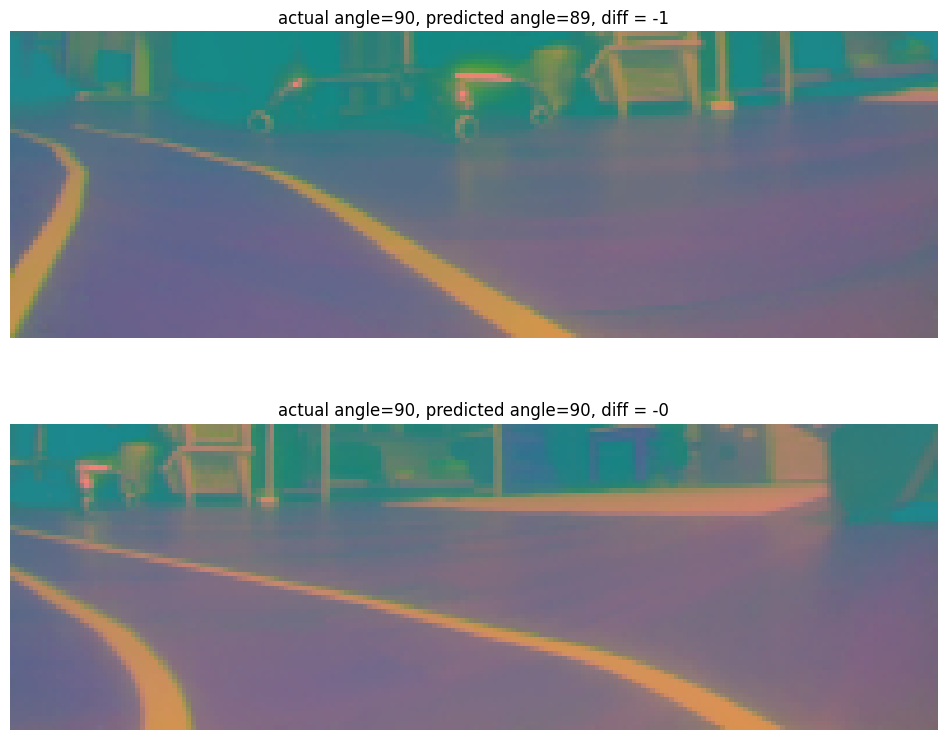

In [33]:
y_pred_pytorch = predict_and_summarize_pytorch(NvidiaModel, checkpoint_path, valid_dataloader, device, n_tests_show=2)

In [34]:
import pickle

In [35]:
model_output_dir = './model/'
history_path = os.path.join(model_output_dir, 'history.pickle')

In [36]:
if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print("Training history loaded successfully.")
else:
    print(f"Error: History file not found at {history_path}")
    history = {'loss': [], 'val_loss': []}

Training history loaded successfully.


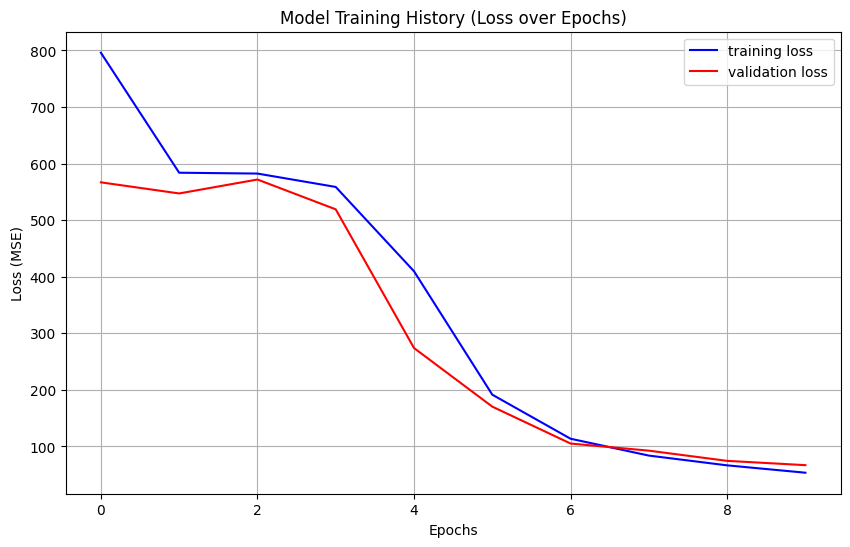

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], color='blue', label='training loss')
plt.plot(history['val_loss'], color='red', label='validation loss')

plt.title('Model Training History (Loss over Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
plt.grid(True)
plt.show()